In [1]:
import gym
import numpy as np

def random_agent(environment='Taxi-v3', n_episodes=500001, print_trace=False):
    """Take all actions randomly as control group for n episodes."""
    env = gym.make(environment)
    s = env.reset()

    r_sums = []

    for episode in range(n_episodes):

    # initialize variables
        done = False
        r_sum = 0
        epoch = 0

        while not done:
            epoch += 1

            a = env.action_space.sample() # select random action
            s_prime, r, done, info = env.step(a) # take action a and collect reward

            # update sum over rewards
            r_sum += r

            if print_trace:
                if episode % 5000 == 0 and episode > 0:
                    print(f'Method: Random actions')
                    print(f'Episode: {episode}')
                    print(f'Last 100 episodes average reward: {np.mean(r_sums[episode-100:episode])}')
        
        r_sums.append(r_sum)
    
    return r_sums


In [2]:
import gym
import numpy as np

env = gym.make('Taxi-v3')
env.reset()

class Agent:
    """The agent can simulate episodes and update its q-table to learn the problem."""
    def __init__(self, method, environment='Taxi-v3', alpha=0.3, gamma=0.9, epsilon=0.5):
        """
        valid options for method: 'q_learning' or 'sarsa'
        """
        self.method = method
        self.env = gym.make(environment)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.n_actions = self.env.action_space.n

        self.q = np.zeros(shape=(25*5*4, self.n_actions)) # initial q-table
        self.pi = np.zeros_like(self.q) # initial policy pi as random policy
        for i in range(self.pi.shape[0]):
            for a in range(self.n_actions):
                self.pi[i, a] = 1 / self.n_actions

    def simulate_episode(self):
        s = self.env.reset() # start new episode

        # initialize variables
        done = False
        r_sum = 0
        epoch = 0
        gamma = self.gamma

        # while episode not finished take step
        while not done:
            epoch += 1

            a = np.argmax(np.cumsum(self.pi[s, :]) > np.random.random()) # select a random action from policy pi
            s_prime, r, done, info = self.env.step(a) # take action a and collect reward

            if self.method == 'sarsa':
                # sarsa: follow policy pi to pick a_prime
                a_prime = np.argmax(np.cumsum(self.pi[s_prime,:]) > np.random.random())
                self.q[s, a] = self.q[s, a] + self.alpha * (r + gamma * self.q[s_prime, a_prime] - self.q[s, a])
            elif self.method == 'q_learning':
                # q-learning: take action a_prime that maximizes q(s', a') (choose randomly for ties)
                a_prime = np.random.choice(np.where(self.q[s_prime] == max(self.q[s_prime]))[0])
                self.q[s, a] = self.q[s, a] + self.alpha * (r + gamma * self.q[s_prime, a_prime] - self.q[s, a])
            else:
                raise Exception('Invalid learning method!')

            # update policy with action a, the action with the highest q(s, a) (choose randomly for ties)
            # with a probability of epsilon a random action is chosen (epsilon-greedy)
            best_a = np.random.choice(np.where(self.q[s] == max(self.q[s]))[0])
            for i in range(self.n_actions):
                if i == best_a:
                    self.pi[s, i] = 1 - (self.n_actions - 1) * (self.epsilon / self.n_actions)
                else:
                    self.pi[s, i] = self.epsilon / self.n_actions

            # if episode is close to finish decay gamma
            if epoch > 185:
                gamma *= 0.875

            # update state and sum over rewards    
            s = s_prime
            r_sum += r

        return r_sum


In [3]:
def train_agent(agent, n_episodes=500001, epsilon_decay=0.99995, alpha_decay=0.99995, print_trace=False):
    """Train the agent on n episodes."""
    r_sums = []

    for episode in range(n_episodes):
        r_sum = agent.simulate_episode() # simulate episode and collect sum over rewards

        agent.epsilon *= epsilon_decay # decrease epsilon
        agent.alpha *= alpha_decay # decrease alpha (learning rate)

        if print_trace:
            if episode % 5000 == 0 and episode > 0:
                print(f'Method: {agent.method}')
                print(f'Episode: {episode}, alpha: {np.round(agent.alpha, 3)}, epsilon: {np.round(agent.epsilon, 3)}')
                print(f'Last 100 episodes average reward: {np.mean(r_sums[episode-100:episode])}')

        r_sums.append(r_sum)
    
    return r_sums

In [4]:
# create agents
sarsa_agent = Agent(method='sarsa')
q_learning_agent = Agent(method='q_learning')

# train agents
r_sums_random = random_agent(print_trace=False)
r_sums_sarsa = train_agent(sarsa_agent, print_trace=False)
r_sums_q_learning = train_agent(q_learning_agent, print_trace=False)

Last 100 episodes averages: 
Random Choice: -3.79
SARSA: 8.11 
Q-Learning: 7.86

Maximum 100 episodes average: 
Random actions   -1.30
Q-Learning        9.00
SARSA             8.92
dtype: float64



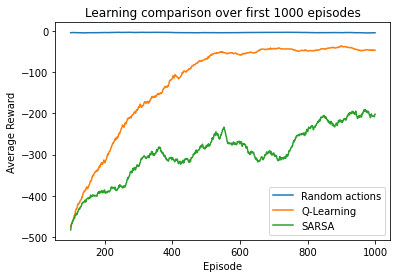

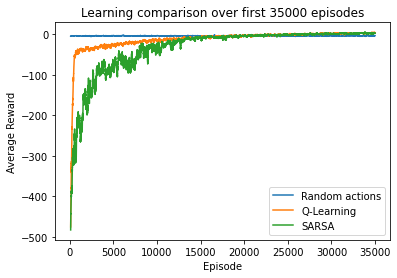

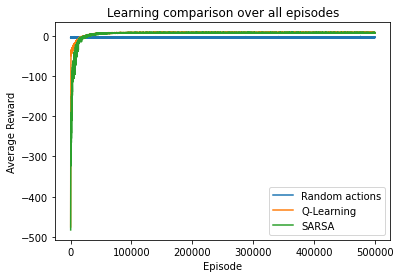

In [5]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.DataFrame({'Random actions': r_sums_random, 'Q-Learning': r_sums_q_learning, 'SARSA': r_sums_sarsa})
df_ma = df.rolling(100, min_periods=100).mean() # 100 episodes mean averages
df_ma.iloc[100:1000].plot(title='Learning comparison over first 1000 episodes', xlabel='Episode', ylabel='Average Reward')
df_ma.iloc[100:35000].plot(title='Learning comparison over first 35000 episodes', xlabel='Episode', ylabel='Average Reward')
df_ma.iloc[100:].plot(title='Learning comparison over all episodes', xlabel='Episode', ylabel='Average Reward')

print(f'Last 100 episodes averages: \nRandom Choice: {np.mean(r_sums_random[-100:])}\nSARSA: {np.mean(r_sums_sarsa[-100:])} \nQ-Learning: {np.mean(r_sums_q_learning[-100:])}\n')
print(f'Maximum 100 episodes average: \n{np.max(df_ma)}\n')

## Reference
[SARSA, Expected SARSA and Q-Learning on the OpenAI Taxi Environment - Tim Roth](https://tomroth.com.au/sarsa-qlearning/)